In [1]:
# typical
import os
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, desc
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window

In [2]:
spark = (SparkSession
     .builder
     .master('local[*]')
     .getOrCreate())

Note: Check the `lab2.py` file for proof of concept.

# Binance

## EDA: Schema

In [3]:
directory = '/mnt/data/public/binance-full-history'
binance = spark.read.parquet(directory)

In [4]:
binance.printSchema()

root
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- quote_asset_volume: float (nullable = true)
 |-- number_of_trades: integer (nullable = true)
 |-- taker_buy_base_asset_volume: float (nullable = true)
 |-- taker_buy_quote_asset_volume: float (nullable = true)
 |-- open_time: timestamp_ntz (nullable = true)



In [5]:
binance.show(5)

+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+
|   open|   high|    low|  close|  volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|
+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+
|4261.48|4261.48|4261.48|4261.48|1.775183|         7564.9067|               3|                   0.075183|                   320.39084|2017-08-17 04:00:00|
|4261.48|4261.48|4261.48|4261.48|     0.0|               0.0|               0|                        0.0|                         0.0|2017-08-17 04:01:00|
|4280.56|4280.56|4280.56|4280.56|0.261074|          1117.543|               2|                   0.261074|                    1117.543|2017-08-17 04:02:00|
|4261.48|4261.48|4261.48|4261.48|0.012008|         51.171852|   

In [6]:
binance.schema

StructType([StructField('open', FloatType(), True), StructField('high', FloatType(), True), StructField('low', FloatType(), True), StructField('close', FloatType(), True), StructField('volume', FloatType(), True), StructField('quote_asset_volume', FloatType(), True), StructField('number_of_trades', IntegerType(), True), StructField('taker_buy_base_asset_volume', FloatType(), True), StructField('taker_buy_quote_asset_volume', FloatType(), True), StructField('open_time', TimestampNTZType(), True)])

## EDA: Individual data files

In [7]:
directory = '/mnt/data/public/binance-full-history'
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]
methods = [re.split(r'-', f.replace('.parquet', ''), 1)[1] for f in files if '-' in f]

# Count each method
method_counts = Counter(methods)
for method, count in method_counts.items():
    print(f"{method}: {count}")

USDT: 272
BUSD: 152
BNB: 82
ETH: 113
BTC: 245
USDC: 14
BIDR: 9
TRY: 24
TUSD: 10
NGN: 2
RUB: 7
EUR: 26
BRL: 14
PAX: 5
TRX: 2
DAI: 5
GBP: 7
IDRT: 2
AUD: 6
UAH: 2
XRP: 1


In [11]:
path = "/mnt/data/public/binance-full-history"
filetypes = ['-USDT', '-BUSD', '-BNB', '-ETH']
filetypes = ['BTC', 'ETH', 'BNB', 'TRX', 'XRP'] # cryptocurrency
filetypes = ['USDT', 'BUSD', 'USDC', 'TUSD', 'PAX', 'DAI', 'BIDR'] # stablecoin
filetypes = ['TRY', 'NGN', 'RUB', 'EUR', 'BRL', 'GBP', 'AUD', 'UAH'] # fiatbacked

# Dictionary to store total size per filetype
sizes = {ftype: 0 for ftype in filetypes}

for dirpath, dirnames, filenames in os.walk(path):
    for f in filenames:
        for filetype in filetypes:
            if filetype in f and f.endswith('.parquet'):
                fp = os.path.join(dirpath, f)
                sizes[filetype] += os.path.getsize(fp)

# Print sizes in GB
for filetype, total_size in sizes.items():
    size_gb = total_size / (1024**3)
    print(f"Total size of '{filetype}' files: {size_gb:.2f} GB")

Total size of 'TRY' files: 0.63 GB
Total size of 'NGN' files: 0.05 GB
Total size of 'RUB' files: 0.23 GB
Total size of 'EUR' files: 0.73 GB
Total size of 'BRL' files: 0.35 GB
Total size of 'GBP' files: 0.26 GB
Total size of 'AUD' files: 0.31 GB
Total size of 'UAH' files: 0.06 GB


### Comparing the three types

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag
from pyspark.sql.window import Window
import pandas as pd
import os

# --- Define categories ---
cryptocurrency = ['BTC', 'ETH', 'BNB', 'TRX', 'XRP']
stablecoin = ['USDT', 'BUSD', 'USDC', 'TUSD', 'PAX', 'DAI', 'BIDR', 'IDRT']
fiat_backed = ['TRY', 'NGN', 'RUB', 'EUR', 'BRL', 'GBP', 'AUD', 'UAH']

spark = SparkSession.builder.master('local[*]').getOrCreate()
directory = '/mnt/data/public/binance-full-history'

# --- Example: pick one representative file from each category ---
files = {
    "Cryptocurrency": "ETH-BTC.parquet",
    "Stablecoin": "BTC-USDT.parquet",
    "Fiat-backed": "BTC-EUR.parquet"
}

results = []

for category, filename in files.items():
    df = spark.read.parquet(os.path.join(directory, filename))
    
    # Compute returns
    w = Window.orderBy("open_time")
    df = df.withColumn("prev_close", lag("close").over(w))
    df = df.withColumn("return", (col("close") - col("prev_close")) / col("prev_close"))
    df = df.dropna()
    
    # Summarize
    summary = df.selectExpr(
        "avg(volume) as avg_volume",
        "stddev(return) as volatility"
    ).toPandas().iloc[0]
    
    results.append({"Category": category, **summary})

# Convert to Pandas for visualization
summary_df = pd.DataFrame(results)
print(summary_df)


         Category  avg_volume  volatility
0  Cryptocurrency  131.209209    0.000996
1      Stablecoin   45.422353    0.001363
2     Fiat-backed    1.458128    0.001193


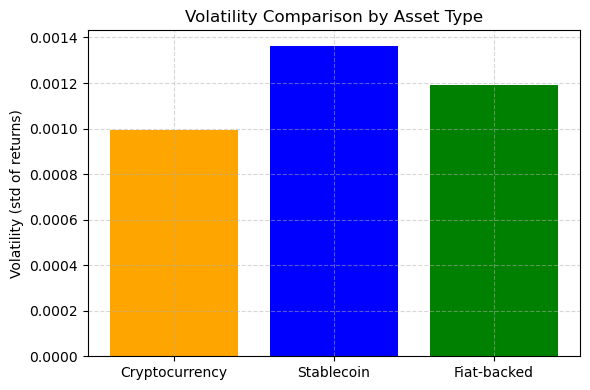

In [10]:
plt.figure(figsize=(6,4))
plt.bar(summary_df["Category"], summary_df["volatility"], color=['orange', 'blue', 'green'])
plt.ylabel("Volatility (std of returns)")
plt.title("Volatility Comparison by Asset Type")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("volatility_comparison.png")
plt.show()